# Construction of Catalytic Potential Models
All models are reconstructed based on the information from Yurkovich et al., “Network-Level Allosteric Effects Are Elucidated by Detailing How Ligand-Binding Events Modulate Utilization of Catalytic Potentials.”

__URL:__ https://doi.org/10.1371/journal.pcbi.1006356

## Setup
#### Import packages

In [1]:
from os import path 

# Disable gurobi logging output for this notebook.
try:
    import gurobipy
    gurobipy.setParam("OutputFlag", 0)
except ImportError:
    pass

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import roadrunner as rr

import mass
from mass import MassConfiguration, Simulation
from mass.io import json
from mass.visualization import plot_time_profile

print("MASSpy version: " + mass.__version__)

Academic license - for non-commercial use only
MASSpy version: 0.1.0a42


#### Set configurations

In [2]:
MASSCONFIGURATION = MassConfiguration()

MASSCONFIGURATION.decimal_precision = 12

# Configure the roadrunner options to prevent excessive logging output and increase performance
rr.Config.setValue(
    rr.Config.ROADRUNNER_DISABLE_PYTHON_DYNAMIC_PROPERTIES, False)
rr.Config.setValue(rr.Config.MAX_OUTPUT_ROWS, 1e6)

## Construct Non-personalized models
### Load Base Models
Load the following models:

\\(\text{Glycolysis}\\ \text{Hemoglobin (Hb)}\\ \text{Hexokinase 1 (HEX1)}\\ \text{Phosphofructokinase (PFK)}\\ \text{Pyruvate Kinase (PYK)}\\)

In [3]:
# Function to print S matrix dimensions
def print_S_dimensions(model):
    print("{0}: Dim(S) = {1}x{2}".format(model.id, *model.S.shape))

# Function to load a model 
def load_model(model_id):
    filename = model_id + ".json"
    filepath = path.realpath(path.join("models", filename))
    model = json.load_json_model(filepath)
    print_S_dimensions(model)
    return model

model_ids = ["glycolysis", "hemoglobin", "HEX1", "PFK", "PYK"]
glycolysis, hemoglobin, HEX1, PFK, PYK = list(map(load_model, model_ids))

for enzyme_module in [HEX1, PFK, PYK]:
    for g in enzyme_module.groups:
        g.id = "_".join((enzyme_module.id, g.id))

Glycolysis: Dim(S) = 20x22
Hemoglobin: Dim(S) = 13x8
HEX1: Dim(S) = 13x8
PFK: Dim(S) = 26x24
PYK: Dim(S) = 31x34


### Load Concentration and Parameter Data

In [4]:
data_filepath = path.realpath(path.join("data", "Non-personalized-data.xlsx"))
data_dict = pd.read_excel(
    data_filepath, sheet_name=["Concentrations", "Fluxes", "Equilibrium Constants", "PERCs"],
    index_col=0)

# Function to load a DataFrame into the necessary format
def load_dataframe(data_key, drop_units=False):
    df = data_dict[data_key]
    df = df.replace("-", np.nan)
    if drop_units:
        df = df.drop("Units", axis=1)
    df.columns = [col.replace(" + ", "_") for col in df.columns]
    return df

conc_df = load_dataframe("Concentrations", drop_units=True)
flux_df = load_dataframe("Fluxes", drop_units=True)
Keqs_df = load_dataframe("Equilibrium Constants", drop_units=False)
perc_df = load_dataframe("PERCs", drop_units=False)

#### Functions to update models with data

In [5]:
# Function to update model concentrations
def update_concentrations(model, verbose=False):
    concentrations = {}
    boundary_conditions = {}
    boundary_compartment = "_" + list(MASSCONFIGURATION.boundary_compartment).pop()

    model_concs = conc_df[model.id]
    model_concs = model_concs.dropna()
    for met, conc in model_concs.to_dict().items():
        if met.endswith(boundary_compartment):
            boundary_conditions[met] = conc
        else:
            concentrations[met] = conc

    model.update_initial_conditions(concentrations, verbose=verbose)
    model.update_parameters(boundary_conditions, verbose=verbose)
    print(model.id + " concentrations updated.")
    
# Function to update model parameter
def update_parameter_type(model, parameter_type, verbose=False):
    param_df, key = {
        "fluxes": (flux_df, "Flux ID"),
        "equilibrium constants": (Keqs_df, "Keq ID"),
        "PERCs": (perc_df, "PERC ID")}[parameter_type]
    model_df = param_df[[key, model.id]]
    model_df = model_df.dropna()
    value_dict = {param_id: float(param_value) for rxn_id, (param_id, param_value) in model_df.iterrows()}
    model.update_parameters(value_dict, verbose=verbose)
    print(" ".join((model.id, parameter_type, "updated.")))

### Create Models and Export
#### Define functions

In [6]:
# Function to add an EnzymeModule to a MassModel
def add_enzyme_to_model(model, enzyme_module):
    new_model = model.merge(enzyme_module, inplace=False)
    new_model.remove_reactions([new_model.reactions.get_by_id(enzyme_module.id)])
    return new_model

# Function to update model values and validate steady state
def update_model_and_simulate(model):
    print_S_dimensions(model)

    update_concentrations(model)
    update_parameter_type(model, "fluxes")
    update_parameter_type(model, "equilibrium constants")
    update_parameter_type(model, "PERCs")

    sim = Simulation(model, verbose=True)
    sim.find_steady_state(model, strategy="simulate", update_values=True,
                          verbose=False, decimal_precision=False,
                          steps=1e5, tfinal=1e4)

    conc_sol, flux_sol = sim.simulate(model, time=(0, 1e3, 1e4+1),
                                      verbose=False, decimal_precision=False)

    fig, ax = plt.subplots(nrows=1, ncols=1,
                           figsize=(6, 4),
                           constrained_layout=True);
    plot_time_profile(
        conc_sol, ax=ax, plot_function="loglog",
        xlabel="Time [hr]", ylabel="Conc. [mM]",
        title=model.id + " Concentration Profile");

# Function to save a model 
def save_model(model):
    filename = model.id + ".json"
    filepath = path.realpath(path.join("models", filename))
    json.save_json_model(mass_model=model, filename=filepath)
    print(" ".join(("Exported", filename)))

#### No Regulation
##### Glycolysis

Glycolysis: Dim(S) = 20x22
Glycolysis concentrations updated.
Glycolysis fluxes updated.
Glycolysis equilibrium constants updated.
Glycolysis PERCs updated.
Successfully loaded MassModel 'Glycolysis' into RoadRunner.
Exported Glycolysis.json


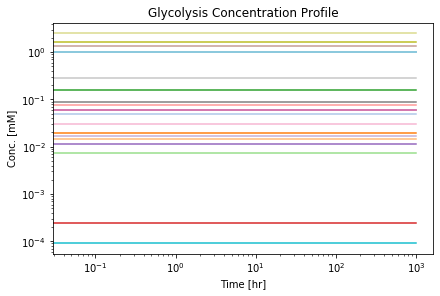

In [7]:
model = glycolysis
update_model_and_simulate(model)
save_model(model)

##### Glycolysis + Hb

Glycolysis_Hb: Dim(S) = 28x30
Glycolysis_Hb concentrations updated.
Glycolysis_Hb fluxes updated.
Glycolysis_Hb equilibrium constants updated.
Glycolysis_Hb PERCs updated.
Successfully loaded MassModel 'Glycolysis_Hb' into RoadRunner.
Exported Glycolysis_Hb.json


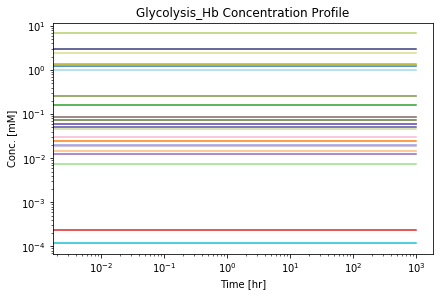

In [8]:
glycolysis_hb = glycolysis.merge(hemoglobin, inplace=False)
glycolysis_hb.id = "Glycolysis_Hb"
model = glycolysis_hb
update_model_and_simulate(model)
save_model(model)

#### Regulation With One Enzyme
##### Glycolysis + PFK

Glycolysis_PFK: Dim(S) = 40x45
Glycolysis_PFK concentrations updated.
Glycolysis_PFK fluxes updated.
Glycolysis_PFK equilibrium constants updated.
Glycolysis_PFK PERCs updated.
Successfully loaded MassModel 'Glycolysis_PFK' into RoadRunner.
Exported Glycolysis_PFK.json


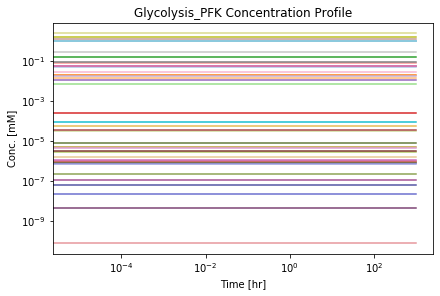

In [9]:
model = add_enzyme_to_model(glycolysis, PFK)
update_model_and_simulate(model)
save_model(model)

##### Glycolysis + PYK

Glycolysis_PYK: Dim(S) = 45x55
Glycolysis_PYK concentrations updated.
Glycolysis_PYK fluxes updated.
Glycolysis_PYK equilibrium constants updated.
Glycolysis_PYK PERCs updated.
Successfully loaded MassModel 'Glycolysis_PYK' into RoadRunner.
Exported Glycolysis_PYK.json


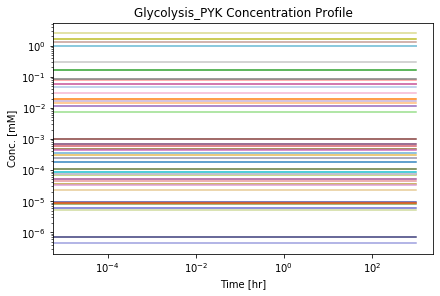

In [10]:
model = add_enzyme_to_model(glycolysis, PYK)
update_model_and_simulate(model)
save_model(model)

##### Glycolysis + Hb + HEX1 

Glycolysis_Hb_HEX1: Dim(S) = 35x37
Glycolysis_Hb_HEX1 concentrations updated.
Glycolysis_Hb_HEX1 fluxes updated.
Glycolysis_Hb_HEX1 equilibrium constants updated.
Glycolysis_Hb_HEX1 PERCs updated.
Successfully loaded MassModel 'Glycolysis_Hb_HEX1' into RoadRunner.
Exported Glycolysis_Hb_HEX1.json


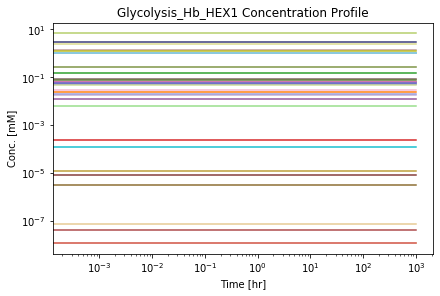

In [11]:
model = add_enzyme_to_model(glycolysis_hb, HEX1)
update_model_and_simulate(model)
save_model(model)

##### Glycolysis + Hb + PFK 

Glycolysis_Hb_PFK: Dim(S) = 48x53
Glycolysis_Hb_PFK concentrations updated.
Glycolysis_Hb_PFK fluxes updated.
Glycolysis_Hb_PFK equilibrium constants updated.
Glycolysis_Hb_PFK PERCs updated.
Successfully loaded MassModel 'Glycolysis_Hb_PFK' into RoadRunner.
Exported Glycolysis_Hb_PFK.json


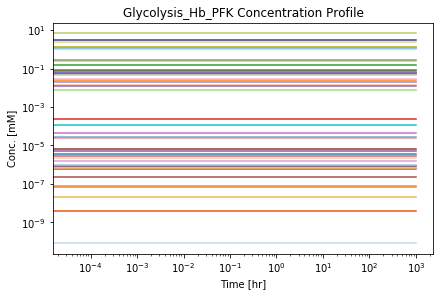

In [12]:
model = add_enzyme_to_model(glycolysis_hb, PFK)
update_model_and_simulate(model)
save_model(model)

##### Glycolysis + Hb + PYK 

Glycolysis_Hb_PYK: Dim(S) = 53x63
Glycolysis_Hb_PYK concentrations updated.
Glycolysis_Hb_PYK fluxes updated.
Glycolysis_Hb_PYK equilibrium constants updated.
Glycolysis_Hb_PYK PERCs updated.
Successfully loaded MassModel 'Glycolysis_Hb_PYK' into RoadRunner.
Exported Glycolysis_Hb_PYK.json


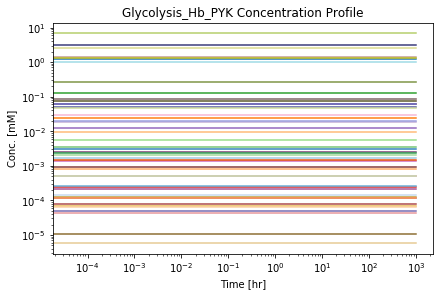

In [13]:
model = add_enzyme_to_model(glycolysis_hb, PYK)
update_model_and_simulate(model)
save_model(model)

#### Regulation With Two Enzymes
##### Glycolysis + PFK + PYK

Glycolysis_PFK_PYK: Dim(S) = 65x78
Glycolysis_PFK_PYK concentrations updated.
Glycolysis_PFK_PYK fluxes updated.
Glycolysis_PFK_PYK equilibrium constants updated.
Glycolysis_PFK_PYK PERCs updated.
Successfully loaded MassModel 'Glycolysis_PFK_PYK' into RoadRunner.
Exported Glycolysis_PFK_PYK.json


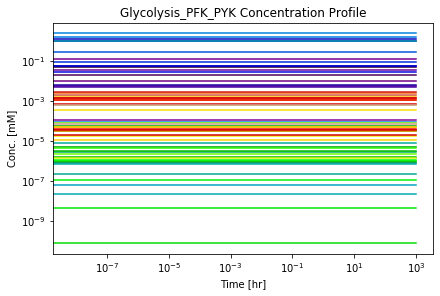

In [14]:
model = add_enzyme_to_model(glycolysis, PFK)
model = add_enzyme_to_model(model, PYK)
update_model_and_simulate(model)
save_model(model)

##### Glycolysis + Hb + PFK + PYK

Glycolysis_Hb_PFK_PYK: Dim(S) = 73x86
Glycolysis_Hb_PFK_PYK concentrations updated.
Glycolysis_Hb_PFK_PYK fluxes updated.
Glycolysis_Hb_PFK_PYK equilibrium constants updated.
Glycolysis_Hb_PFK_PYK PERCs updated.
Successfully loaded MassModel 'Glycolysis_Hb_PFK_PYK' into RoadRunner.
Exported Glycolysis_Hb_PFK_PYK.json


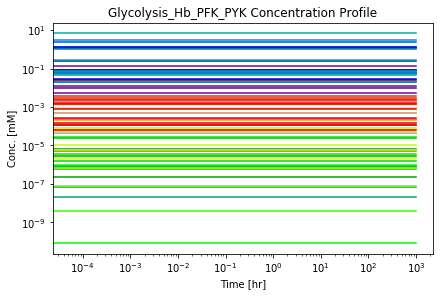

In [15]:
model = add_enzyme_to_model(glycolysis_hb, PFK)
model = add_enzyme_to_model(model, PYK)
update_model_and_simulate(model)
save_model(model)

##### Glycolysis + Hb + HEX1 + PFK

Glycolysis_Hb_HEX1_PFK: Dim(S) = 55x60
Glycolysis_Hb_HEX1_PFK concentrations updated.
Glycolysis_Hb_HEX1_PFK fluxes updated.
Glycolysis_Hb_HEX1_PFK equilibrium constants updated.
Glycolysis_Hb_HEX1_PFK PERCs updated.
Successfully loaded MassModel 'Glycolysis_Hb_HEX1_PFK' into RoadRunner.
Exported Glycolysis_Hb_HEX1_PFK.json


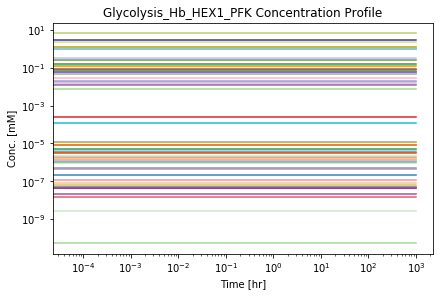

In [16]:
model = add_enzyme_to_model(glycolysis_hb, HEX1)
model = add_enzyme_to_model(model, PFK)
update_model_and_simulate(model)
save_model(model)

##### Glycolysis + Hb + HEX1 + PYK

Glycolysis_Hb_HEX1_PYK: Dim(S) = 60x70
Glycolysis_Hb_HEX1_PYK concentrations updated.
Glycolysis_Hb_HEX1_PYK fluxes updated.
Glycolysis_Hb_HEX1_PYK equilibrium constants updated.
Glycolysis_Hb_HEX1_PYK PERCs updated.
Successfully loaded MassModel 'Glycolysis_Hb_HEX1_PYK' into RoadRunner.
Exported Glycolysis_Hb_HEX1_PYK.json


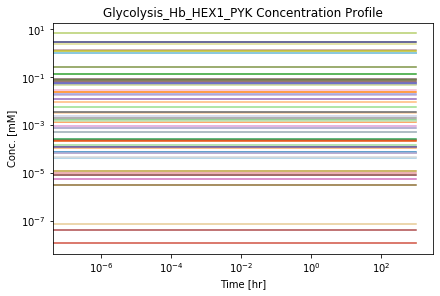

In [17]:
model = add_enzyme_to_model(glycolysis_hb, HEX1)
model = add_enzyme_to_model(model, PYK)
update_model_and_simulate(model)
save_model(model)

#### Regulation With Three Enzymes
##### Glycolysis + Hb + HEX1 + PFK + PYK

Glycolysis_Hb_HEX1_PFK_PYK: Dim(S) = 80x93
Glycolysis_Hb_HEX1_PFK_PYK concentrations updated.
Glycolysis_Hb_HEX1_PFK_PYK fluxes updated.
Glycolysis_Hb_HEX1_PFK_PYK equilibrium constants updated.
Glycolysis_Hb_HEX1_PFK_PYK PERCs updated.
Successfully loaded MassModel 'Glycolysis_Hb_HEX1_PFK_PYK' into RoadRunner.
Exported Glycolysis_FKRM.json


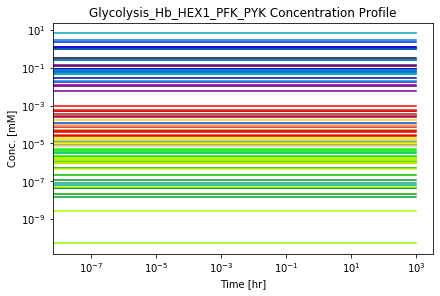

In [18]:
model = add_enzyme_to_model(glycolysis_hb, HEX1)
model = add_enzyme_to_model(model, PFK)
model = add_enzyme_to_model(model, PYK)
update_model_and_simulate(model)
model.id = "Glycolysis_FKRM"
save_model(model)